In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 24,'lines.linewidth':3})
from astropy.io import fits # /!\ You'll have to install the package astropy to use this!

ddir='' #your data directory, like '/Users/ayep/research/data'; starting with "/Users" makes code easily portable to other computers :)
pdir='' #your plot directory, like '/Users/ayep/research/plot'

#My everyday functions:
#open data files line-by-line but split up by tab ('\t')
def opendat(dir,filename): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split('\t')] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

#open data files into well-named variables:
def opendat2(dirr,filename,params): #Use as var,var,var...=opendat2(dir,'filename',['keys']).
    dat,label=opendat(dirr,filename)  #Get keys by first leaving ['keys'] blank: opendat2(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

## Spectra from .fits Files

Fortunately Python offers packages (especially astropy) to deal with spectra .fits files. :) Some spectra have wavelength and flux, some only have flux, some split them into orders.... Every telescope spits out data a bit differently, but the first step is just to open it. I happen to have CHIRON data, which has wavelength and flux and several orders (that is, separate wavelength-range regions).

In [19]:
#a few functions

#wavelength, flux, because I'm so lazy that I have a funciton for this.... Set up for CHIRON's format
def wf(dat,o): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=[d[0] for d in dat[o]]
    f=[d[1] for d in dat[o]]
    return w,f

#normalize
#Blaze file:
bdat=opendat2(ddir,'blaze.dat',['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'])

#Orders of interest:
os=[0,1,2,3,5,6,7,10,11,12,13,14,17,18,19,20,21,22,23,24,25,28,31,32,33,34,36,37,40,52] #of interest; dodge pressure-broadened (wide wings) and telluric: skip any with sharp lines in B star! ex: 26,29,35,38,39(butHa),43-48,51(best!),53-7 have tel. lines.

def useblaze(fraw,head,o): #flux of object, order of interest
    fb=bdat[o]
    #factor=np.max(fb)/(np.max(f[350:375])-np.std(f[350:375]))
    #fn=np.array(f)/(np.array(fb)*(np.max(f[350:375])-np.std(f[350:375]))/np.max(fb))
    
    gain=float(head['GAIN'])
    RN=float(head['RON'])
    K=2.5
    
    mean=np.mean(fraw[325:425])
    std=np.std(fraw[325:425])
    
    #kill cosmic rays, particularly in peak region
    f=[fraw[0],]+[fraw[i] if fraw[i]<mean+2.5*std else np.mean((fraw[i-1],fraw[i+1])) for i in range(1,len(fraw)-1)]+[fraw[-1],]
    
    SNR=np.array(f)*gain/np.sqrt(np.array(f)*gain+K*RN**2.)    
    SNRb=np.array(fb)*gain/np.sqrt(np.array(fb)*gain+K*RN**2.)
    #SNR=signal/noise --> noise=signal/SNR
    #f=signal+noise=signal+signal/SNR=signal(1+1/SNR)
    #signal=f/(1+1/SNR)
    #scale max signal of blaze to max signal of target.
    
    signalmax=sorted(f[325:425])[-6]/(1.+1./np.mean(SNR[325:425])) #cut the highest
    signalbmax=sorted(fb[325:425])[-6]/(1.+1./np.mean(SNRb[325:425])) #cut the highest
    scaleblaze=signalmax/signalbmax
    
    #fn=np.array(f)/(np.array(fb)*np.max(f[350:375])/np.max(fb)) #low-noise standards work better like this.
    fn=np.array(fraw)/(np.array(fb)*scaleblaze)
    return fn

#convenient plotting functions
def plott(w,fn,o):
    plt.figure(figsize=(20,10))
    plt.plot(w,fn,lw=2)
    plt.plot((w[0],w[-1]),(1,1),lw=1,ls='--',color='gray')
    plt.ylim(0,4)
    plt.title('Order '+str(o))

['#fluxes', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


In [20]:
#open .fits files
hdulist=fits.open('SampleSpectrum_G3V.fits') # opens the fits file
#hdulist.info() #can toggle to view some file info
dat=hdulist[0].data #puts the spectrum data itself into a variable called dat
head=hdulist[0].header #puts header information (RA, Dec, time of observation, etc.) into head
hdulist.close() #closes .fits file now that you've taken the data you want

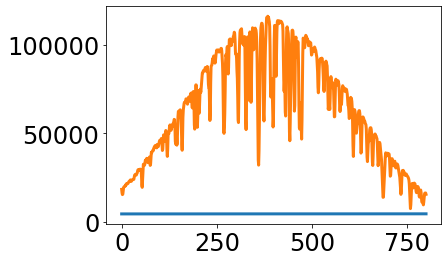

In [21]:
#View an order:

plt.plot(dat[0])

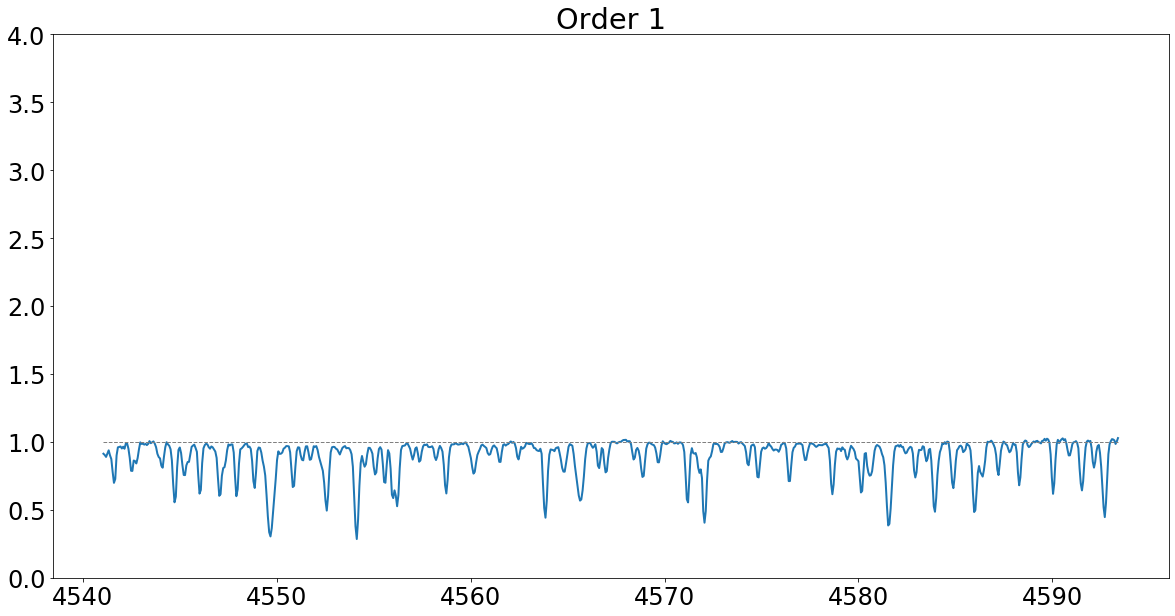

In [22]:
#I've made a function, so view it this way:

w,f=wf(dat,1)

#normalize:
fn=useblaze(f,head,1)

#plot:
plott(w,fn,1)